# 🔬 Clinical Trial Outcome Benchmark Notebook

*A self-contained analysis reproducing evaluations from our [CTO \[1\]](https://chufangao.github.io/CTOD/) framework, comparing label predictions on manually annotated trial splits.*

---

## 🎯 Objectives

In this notebook, we'll explore:

1. � **Feature Engineering**  
   Extract text features from ClinicalTrials.gov records

2. 📂 **Data Integration**  
   Load clinical trial success/failure labels from:
   - Our automated CTO framework
   - [TOP \[2\]](https://github.com/futianfan/clinical-trial-outcome-prediction) baseline
   - Human expert annotations

3. 🤖 **Model Benchmarking**  
   Train/test RandomForest classifiers to compare performance across:
   - CTO predictions
   - TOP predictions
   - Human-generated labels

---

## 📚 References

[1] 📜 **CTO Framework**  
Gao, C., et al. (2024). *Automatically Labeling Clinical Trial Outcomes: A Large-Scale Benchmark for Drug Development*. arXiv:2406.10292.  
[CTO Project Page](https://chufangao.github.io/CTOD/)

[2] 🧠 **TOP Model**  
Fu, T., et al. (2022). *Hint: Hierarchical interaction network for clinical-trial-outcome predictions*. Patterns, 3(4).  
[GitHub Repository](https://github.com/futianfan/clinical-trial-outcome-prediction)


In [1]:
# # ================ First, let us get started by cloning everyting in ================
!git clone https://github.com/chufangao/CTOD.git
!git clone https://github.com/futianfan/clinical-trial-outcome-prediction.git
!wget https://huggingface.co/datasets/chufangao/CTO/resolve/main/CTTI.zip
CTTI_PATH = './CTTI.zip'

Cloning into 'CTOD'...
remote: Enumerating objects: 627, done.
remote: Counting objects: 100% (138/138), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 627 (delta 95), reused 50 (delta 37), pack-reused 489 (from 1)
Receiving objects: 100% (627/627), 43.98 MiB | 8.75 MiB/s, done.
Resolving deltas: 100% (370/370), done.
Cloning into 'clinical-trial-outcome-prediction'...
remote: Enumerating objects: 932, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 932 (delta 19), reused 40 (delta 5), pack-reused 863 (from 1)
Receiving objects: 100% (932/932), 104.38 MiB | 8.46 MiB/s, done.
Resolving deltas: 100% (534/534), done.
Updating files: 100% (119/119), done.
--2025-03-26 02:04:51--  https://huggingface.co/datasets/chufangao/CTO/resolve/main/CTTI.zip
Resolving huggingface.co (huggingface.co)... 18.172.134.124, 18.172.134.4, 18.172.134.24, ...
Connecting to huggingface.co (huggingface.co)|18.172.134.124|:

In [2]:
# # if you want to use the latest version of clinical trials instead, uncomment and run this cell
# !pip install selenium
# !python ./CTOD/download_ctti.py
# CTTI_PATH = './downloads/CTTI_new.zip'

# 🏗️ Building Clinical Trial Text Features

**Transforming raw trial data into predictive power** 💪

This cell constructs the foundational text features that will fuel our outcome prediction model. Here's the magic happening behind the scenes:

📦 **Data Extraction**  
We unpack ClinicalTrials.gov's rich dataset (CTTI) containing:
- `studies.txt`: Core trial metadata
- `browse_conditions.txt`: Disease classifications
- `interventions.txt`: Treatment details
- `eligibilities.txt`: Patient criteria
- `designs.txt`: Study methodology

🔧 **Feature Engineering Pipeline**  
We create text features combining:  
1. **Phase** - The phase of the trial, e.g. Phase 1, Phase 3, ...
1. **Diseases** 🦠 - Aggregate MeSH terms per trial
2. **Interventions** 💉 - Clean and lowercase treatment names, combining multiple interventions
3. **Eligibility Criteria** 👥 - Process eligibility criteria for patients recruited into the trial
4. **Study Architecture** 🏥 - Blend design elements into single descriptor: *Allocation + Model + Purpose + Masking + Perspective*
5. **Temporal Context** 📅 - Extract completion year from dates

*The resulting 'features' column becomes our model's language for understanding trial outcomes!*

In [3]:
# ================ building text features from CTTI ================
import glob
import os
import pandas as pd
import numpy as np
import zipfile

def load_all_studies_with_features(CTTI_PATH):
    with zipfile.ZipFile(CTTI_PATH, 'r') as zip_ref:
        names = zip_ref.namelist()
        all_studies = pd.read_csv(zip_ref.open([name for name in names if name.split("/")[-1]=='studies.txt'][0]), sep='|')
        diseases = pd.read_csv(zip_ref.open([name for name in names if name.split("/")[-1]=='browse_conditions.txt'][0]), sep='|')
        interventions = pd.read_csv(zip_ref.open([name for name in names if name.split("/")[-1]=='interventions.txt'][0]), sep='|')
        criteria = pd.read_csv(zip_ref.open([name for name in names if name.split("/")[-1]=='eligibilities.txt'][0]), sep='|')
        designs = pd.read_csv(zip_ref.open([name for name in names if name.split("/")[-1]=='designs.txt'][0]), sep='|')

    diseases = diseases.groupby('nct_id')['downcase_mesh_term'].apply(lambda x: ' '.join(list(x))).reset_index().rename(columns={'downcase_mesh_term': 'diseases'})
    diseases.fillna('', inplace=True)

    interventions = interventions.dropna(subset=['name'])
    interventions['name'] = interventions['name'].str.lower()
    interventions = interventions.groupby('nct_id')['name'].apply(lambda x: ' '.join(list(x))).reset_index().rename(columns={'name': 'interventions'})
    interventions.fillna('', inplace=True)

    criteria = criteria.dropna(subset=['criteria'])
    criteria.drop_duplicates(subset=['nct_id'], inplace=True)
    criteria['criteria'] = criteria['criteria'].str.lower()
    criteria.fillna('', inplace=True)

    designs = designs.fillna('')
    designs['design'] = designs['allocation'] + ' ' + designs['intervention_model'] + ' ' + designs['observational_model'] + ' ' + designs['primary_purpose'] + ' ' + designs['time_perspective'] + ' ' + designs['masking']
    designs['design'] = designs['design'].str.lower()
    designs = designs[['nct_id', 'design']]
    designs.drop_duplicates(subset=['nct_id'], inplace=True)
    designs.fillna('', inplace=True)

    # save years for later
    all_studies.dropna(subset=['completion_date'], inplace=True)
    all_studies['year'] = all_studies['completion_date'].apply(lambda x: int(x.split('-')[0]))

    all_studies = all_studies.merge(diseases, on='nct_id', how='left')
    all_studies = all_studies.merge(interventions, on='nct_id', how='left')
    all_studies = all_studies.merge(criteria, on='nct_id', how='left')
    all_studies = all_studies.merge(designs, on='nct_id', how='left')
    all_studies['features'] = all_studies['phase'] + ' '  + all_studies['diseases'] + ' '  + all_studies['interventions'] + ' ' + all_studies['design'] + ' ' + all_studies['criteria']
    all_studies = all_studies[all_studies['features'].str.len() > 0]
    return all_studies

#🧩 **Processing Labels**  

## Data loading and strict separation of CTO predictions and human labels

In [9]:
# loading in the predictions
import pandas as pd
import sys
import zipfile

CTO_GOLD_PATH="https://huggingface.co/datasets/chufangao/CTO/raw/main/human_labels_2020_2024/human_labels_2020_2024.csv"
CTO_phase1_preds = pd.read_csv("https://huggingface.co/datasets/chufangao/CTO/raw/main/phase1_CTO_rf.csv")
CTO_phase2_preds = pd.read_csv("https://huggingface.co/datasets/chufangao/CTO/raw/main/phase2_CTO_rf.csv")
CTO_phase3_preds = pd.read_csv("https://huggingface.co/datasets/chufangao/CTO/raw/main/phase3_CTO_rf.csv")
labelmodel_label = pd.concat([CTO_phase1_preds, CTO_phase2_preds, CTO_phase3_preds])
labelmodel_label = labelmodel_label[['nct_id', 'pred', 'pred_proba']].drop_duplicates(subset=['nct_id'])
# print(labelmodel_label['pred'].value_counts())

cto_gold = pd.read_csv(CTO_GOLD_PATH)
# print(cto_gold)
cto_gold = cto_gold[cto_gold['labels'] != -1]
# print(cto_gold['labels'].value_counts())

labelmodel_label = labelmodel_label[~labelmodel_label['nct_id'].isin(cto_gold['nct_id'])]
# print(labelmodel_label['pred'].value_counts())

all_studies = load_all_studies_with_features(CTTI_PATH)

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

## 🤖 CTO label prediction processing-- Progressive evidence cascade:
1. Start with trial status labels - Marks `0` for red flags: *Terminated/Withdrawn/Suspended* and `1` for clear success: *Approved for Marketing*  
2. Augment with p-value confirmations - primary outcome p-values < 0.05  
3. Fill gaps with CTO model predictions - Combine all phase-specific prediction probabilities
4. Final test set uses only human-verified labels

In [ ]:
# ========== correspond features to CTO labels ==========
def lf_status(path):
    with zipfile.ZipFile(CTTI_PATH, 'r') as zip_ref:
        names = zip_ref.namelist()
        df = pd.read_csv(zip_ref.open([name for name in names if name.split("/")[-1]=='studies.txt'][0]), sep='|')
    df['lf'] = -1
    # lower case all status and replace '_' with ' '
    df['overall_status'] = df['overall_status'].str.lower().str.replace('_', ' ')
    df.loc[df['overall_status'].isin(['terminated', 'withdrawn', 'suspended', 'withheld', 'no longer available', 'temporarily not available']),['lf']] = 0
    df.loc[df['overall_status'].isin(['approved for marketing']),['lf']] = 1
    df['lf'] = df['lf'].fillna(-1).astype('int')
    return df

def lf_pvalues(path): # any p-value sig is good
    with zipfile.ZipFile(CTTI_PATH, 'r') as zip_ref:
        names = zip_ref.namelist()
        df = pd.read_csv(zip_ref.open([name for name in names if name.split("/")[-1]=='outcome_analyses.txt'][0]), sep='|')
        outcomes_df = pd.read_csv(zip_ref.open([name for name in names if name.split("/")[-1]=='outcomes.txt'][0]), sep='|')
    primary_outcomes = outcomes_df[outcomes_df['outcome_type'].str.lower()=='primary']
    df = df[df['outcome_id'].isin(primary_outcomes['id'])]
    df.dropna(subset=['p_value'], inplace=True)

    df['lf'] = df['p_value'] < .05
    df = df.groupby('nct_id')[['lf', 'p_value']].mean().reset_index() # multiple pvalues per nct_id
    df['lf'] = df['p_value'] > 0 # any p-value sig is good
    df['lf'] = df['lf'].fillna(-1).astype('int')
    return df

train_studies = all_studies[all_studies['nct_id'].isin(labelmodel_label['nct_id'])]
train_studies['label'] = -1

status_lf = lf_status(path=CTTI_PATH)
status_lf = status_lf[status_lf['lf']!=-1]
status_mapping = status_lf[['nct_id', 'lf']].set_index('nct_id').to_dict()['lf']
train_studies['label'] = train_studies.apply(lambda x: status_mapping[x['nct_id']] if x['nct_id'] in status_mapping else x['label'], axis=1)
print(train_studies['label'].value_counts())

# apply pvalue mapping where pvalue < 0.05 (conservative, some studies may not have pvalues but are still positive)
pvalue_lf = lf_pvalues(path=CTTI_PATH)
pvalue_lf = pvalue_lf[pvalue_lf['lf']==1]
pvalue_mapping = pvalue_lf[['nct_id', 'lf']].set_index('nct_id').to_dict()['lf']
# map lf == -1 to pvalue lf
train_studies.loc[train_studies['label']==-1, 'label'] = train_studies.loc[train_studies['label']==-1].apply(lambda x: pvalue_mapping[x['nct_id']] if x['nct_id'] in pvalue_mapping else x['label'], axis=1)
print(train_studies['label'].value_counts())

# apply labelmodel mapping where studies['label'] == -1
labelmodel_mapping = labelmodel_label.set_index('nct_id').to_dict()['pred_proba']
train_studies.loc[train_studies['label']==-1, 'label'] = train_studies.loc[train_studies['label']==-1].apply(lambda x: labelmodel_mapping[x['nct_id']] if x['nct_id'] in labelmodel_mapping else x['label'], axis=1)
print(train_studies['label'].value_counts())

# save for later
train_studies.to_csv('../train_studies.csv', index=False)

## 🤖 CTO label prediction processing-- Progressive evidence cascade:
1. Start with trial status labels - Marks `0` for red flags: *Terminated/Withdrawn/Suspended* and `1` for clear success: *Approved for Marketing*  
2. Augment with p-value confirmations - primary outcome p-values < 0.05  
3. Fill gaps with CTO model predictions - Combine all phase-specific prediction probabilities
4. Final test set uses only human-verified labels

In [10]:
# ========== correspond features to human labels ==========
test_studies = all_studies[all_studies['nct_id'].isin(cto_gold['nct_id'])]
gold_mapping = cto_gold.set_index('nct_id').to_dict()['labels']
test_studies['label'] = test_studies['nct_id'].apply(lambda x: gold_mapping[x] if x in gold_mapping else -1)
print(test_studies['label'].value_counts())

# save for later
test_studies.to_csv('../test_studies.csv', index=False)

label
0.0    6856
1.0    3284
Name: count, dtype: int64


In [ ]:
# ========== correspond features to TOP labels ==========
import pandas as pd
import numpy as np
import os
import glob
HINT_PATH = './clinical-trial-outcome-prediction/data'

hint_train = glob.glob(os.path.join(HINT_PATH, "phase*train.csv")) + glob.glob(os.path.join(HINT_PATH, "phase*valid.csv")) + glob.glob(os.path.join(HINT_PATH, "phase*test.csv"))
hint_train = pd.concat((pd.read_csv(f) for f in hint_train))
hint_train.drop_duplicates(subset=['nctid'], inplace=True)
hint_train_mapping = hint_train.set_index('nctid').to_dict()['label']
# all_studies = load_all_studies_with_features(CTTI_PATH)
hint_train_studies = all_studies[all_studies['nct_id'].isin(hint_train['nctid'])]
hint_train_studies['label'] = hint_train_studies['nct_id'].apply(lambda x: hint_train_mapping[x] if x in hint_train_mapping else -1)

# hint_train_studies = hint_train_studies[hint_train_studies['year'] <= 2020]
print(hint_train_studies['label'].value_counts())
hint_train_studies.to_csv('hint_train_studies.csv', index=False)

# Running baselines

In [6]:
# ================ running baselines ================
import numpy as np
from sklearn.metrics import f1_score, average_precision_score, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
import pandas as pd
import sklearn
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE, ADASYN
import warnings
import copy
warnings.filterwarnings("ignore")

def bootstrap_eval(y_true, y_pred, y_prob, num_samples=100):
    f1s = []
    aps = []
    rocs = []
    for _ in range(num_samples):
        indices = np.random.choice(len(y_true), len(y_true), replace=True)
        # convert to multiclass for precision recall curve
        y_true_multi = np.zeros((len(y_true), 2))
        y_true_multi[np.arange(len(y_true)), y_true] = 1
        y_pred_multi = np.zeros((len(y_pred), 2))
        y_pred_multi[np.arange(len(y_pred)), y_pred] = 1
        y_prob_multi = np.zeros((len(y_prob), 2))
        y_prob_multi[np.arange(len(y_prob)), y_pred] = y_prob

        # accs.append(np.mean(y_true[indices] == y_pred[indices]))
        f1s.append(f1_score(y_true_multi[indices], y_pred_multi[indices], average='weighted'))
        aps.append(average_precision_score(y_true_multi[indices], y_prob_multi[indices], average='weighted'))
        rocs.append(roc_auc_score(y_true_multi[indices], y_pred_multi[indices], average='weighted'))
    return np.mean(f1s), np.std(f1s), np.mean(aps), np.std(aps), np.mean(rocs), np.std(rocs)

def get_conditions_mesh(CTTI_PATH, human_labels_path, top_k=10):
    human_labels = pd.read_csv(human_labels_path)
    with zipfile.ZipFile(CTTI_PATH, 'r') as zip_ref:
        names = zip_ref.namelist()
        conditions_df = pd.read_csv(zip_ref.open([name for name in names if name.split("/")[-1]=='browse_conditions.txt'][0]), sep='|')

    # conditions_df = pd.read_csv(os.path.join(CTTI_PATH, 'browse_conditions.txt'), sep='|', low_memory=False)
    conditions_df = conditions_df[conditions_df['mesh_type'] == 'mesh-ancestor']
    conditions_df_copy = copy.deepcopy(conditions_df.copy())
    conditions_df = conditions_df[conditions_df['nct_id'].isin(set(human_labels['nct_id']))]

    top_term = [conditions_df['downcase_mesh_term'].value_counts().index[0]]
    for k in range(top_k):
        nct_ids = set(conditions_df[conditions_df['downcase_mesh_term'].str.contains(top_term[-1])]['nct_id'].unique())
        conditions_df = conditions_df[~conditions_df['nct_id'].isin(nct_ids)]
        # print('remaining', conditions_df['downcase_mesh_term'].value_counts())
        top_term.append(conditions_df['downcase_mesh_term'].value_counts().index[0])

    mesh_dict =  {top_term[i]: set(conditions_df_copy[conditions_df_copy['downcase_mesh_term'].str.contains(top_term[i])]['nct_id'].unique())
                  for i in range(len(top_term))}

    return mesh_dict

output = []
train_mode_years = [('TOP', 2021), ('manual', 2021), ('CTO', 2021),
                    ('TOP', 2022), ('manual', 2022), ('CTO', 2022),
                    ('TOP', 2023), ('manual', 2023), ('CTO', 2023),
                    ('TOP', 2024), ('manual', 2024), ('CTO', 2024)]
# train_mode_years = [('TOP', 'manual_2022'),]
# train_mode_years = [('CTO', 'manual_2022'),('manual', 'manual_2022'), ('TOP', 'manual_2022')]
mesh_dict = get_conditions_mesh(CTTI_PATH, human_labels_path="https://huggingface.co/datasets/chufangao/CTO/raw/main/human_labels_2020_2024/human_labels_2020_2024.csv")
disease = ''

for train_mode, year in train_mode_years:
    if train_mode == 'TOP':
        test_studies = pd.read_csv('../test_studies.csv')
    # train_studies, test_studies = test_studies[test_studies['year']<2022], test_studies[test_studies['year']>=2022]
        # train_studies = test_studies[(test_studies['year']<year) & (test_studies['year']>=year-1)]
        # train_studies = test_studies[(test_studies['year']<year)]
        if type(year) == str and year=='manual_2022':
            test_studies = test_studies[(test_studies['year']>=2022)]
        elif type(year) is int:
            test_studies = test_studies[(test_studies['year']>=year) & (test_studies['year']<year+1)]
        train_studies = hint_train_studies.copy()
    elif train_mode == 'manual':
        test_studies = pd.read_csv('../test_studies.csv')
        if type(year) == str and year=='manual_2022':
            train_studies = test_studies[(test_studies['year']<2022)]
            test_studies = test_studies[(test_studies['year']>=2022)]
        elif type(year) is int:
            train_studies = test_studies[(test_studies['year']<year)]
            test_studies = test_studies[(test_studies['year']>=year) & (test_studies['year']<year+1)]
    elif train_mode == 'CTO':
        train_studies = pd.read_csv('../train_studies.csv')
        test_studies = pd.read_csv('../test_studies.csv')
        if type(year) == str and year=='manual_2022':
            train_studies = train_studies[(train_studies['year']<2022)]
            test_studies = test_studies[(test_studies['year']>=2022)]
        elif type(year) is int:
            train_studies = train_studies[(train_studies['year']<year) & (train_studies['year']>=2015)]
            test_studies = test_studies[(test_studies['year']>=year) & (test_studies['year']<year+1)]
            # train_studies = train_studies[(train_studies['year']<year) & (train_studies['year']>=year-1)]

    # ========== uncomment and unindent to run on all diseases ==========
    # org_train_studies = train_studies.copy()
    # org_test_studies = test_studies.copy()
    # for disease, disease_ncts in mesh_dict.items():
    #     train_studies = org_train_studies[org_train_studies['nct_id'].isin(disease_ncts)]
    #     test_studies = org_test_studies[org_test_studies['nct_id'].isin(disease_ncts)]
    #     print(disease, train_studies.shape, test_studies.shape, org_train_studies.shape, org_test_studies.shape, len(disease_ncts))

    # ========== get tfidf features ==========
    tfidf = TfidfVectorizer(max_features=2048, stop_words='english')
    X_train = tfidf.fit_transform(train_studies['features'])
    y_train = (train_studies['label'].values > 0.75).astype(int)
    # y_train = train_studies['label'].values

    X_test = tfidf.transform(test_studies['features'])
    y_test = (test_studies['label'].values > .75).astype(int)

    print('y_train', np.unique(y_train, return_counts=True))
    print('y_test', np.unique(y_test, return_counts=True))

    # ========== train models ==========
    # for model_name in ['RF', 'LR','XGBoost', 'MLP',  'SVM', ]:
    for model_name in ['RF', ]:
        # for phase in ['1', '2', '3']:
        for phase in ['all']:
            if model_name == 'RF':
                model = RandomForestClassifier(n_estimators=300, random_state=0, max_depth=8, n_jobs=4)
            elif model_name == 'LR':
                model = LogisticRegression(max_iter=2000, random_state=0, penalty='l2')
            elif model_name == 'SVM':
                # model = LinearSVC(dual="auto", max_iter=10000, random_state=0)
                model = CalibratedClassifierCV(model)
                # model = SVC(kernel='linear', probability=True, random_state=0)
            elif model_name == 'XGBoost':
                model = XGBClassifier(n_estimators=1000, random_state=0, max_depth=8, n_jobs=4)
            elif model_name == 'MLP':
                model = MLPClassifier(hidden_layer_sizes=(64, 64), max_iter=2000, random_state=0)
            else:
                raise ValueError('Unknown model name')

            if phase == 'all':
                train_phase_mask = np.ones(len(train_studies)).astype(bool)
                test_phase_mask = np.ones(len(test_studies)).astype(bool)
            else:
                train_phase_mask = train_studies['phase'].str.lower().str.contains(phase)
                train_phase_mask=train_phase_mask.values
                test_phase_mask = test_studies['phase'].str.lower().str.contains(phase)
                test_phase_mask=test_phase_mask.values

            # print('phase train', np.unique(y_train[train_phase_mask], return_counts=True))
            # print('phase test', np.unique(y_test[test_phase_mask], return_counts=True))

            X_train_, y_train_ = SMOTE().fit_resample(X_train[train_phase_mask], y_train[train_phase_mask])
            # print('phase train after smote', np.unique(y_train_, return_counts=True))
            model.fit(X_train_, y_train_)
            # model.fit(X_train[train_phase_mask], y_train[train_phase_mask])
            pred = model.predict(X_test)
            # print('phase pred', np.unique(pred[test_phase_mask], return_counts=True))
            prob = model.predict_proba(X_test)[:, 1]

            # if model_name == 'XGBoost':
            test_studies.loc[test_phase_mask, ['pred']] = pred[test_phase_mask]
            test_studies.loc[test_phase_mask, ['prob']] = prob[test_phase_mask]

            # print(phase, test_df_subset.shape)
            # print(classification_report(test_df_subset['label'], test_df_subset['pred']))
            f1_mean, f1_std, ap_mean, ap_std, roc_mean, roc_std = bootstrap_eval(y_test[test_phase_mask], pred[test_phase_mask], prob[test_phase_mask])
            print(f"{disease}, {train_mode}, {year}, {phase}, {model_name}, {f1_mean:.3f}, {f1_std:.3f}, {ap_mean:.3f}, {ap_std:.3f}, {roc_mean:.3f}, {roc_std:.3f}")
            output.append([disease, train_mode, year, phase, model_name, f1_mean, f1_std, ap_mean, ap_std, roc_mean, roc_std])
            # print(f"{train_mode}, {year}, {phase}, {model_name}, {f1_mean:.3f}, {f1_std:.3f}, {ap_mean:.3f}, {ap_std:.3f}, {roc_mean:.3f}, {roc_std:.3f}")
            # output.append([train_mode, year, phase, model_name, f1_mean, f1_std, ap_mean, ap_std, roc_mean, roc_std])
            # break
# output = pd.DataFrame(output, columns=['year', 'phase', 'model', 'f1_mean', 'f1_std', 'ap_mean', 'ap_std', 'roc_mean', 'roc_std'])
# output = pd.DataFrame(output, columns=['train_mode', 'year', 'phase', 'model', 'f1_mean', 'f1_std', 'ap_mean', 'ap_std', 'roc_mean', 'roc_std'])
output = pd.DataFrame(output, columns=['disease', 'train_mode', 'year', 'phase', 'model', 'f1_mean', 'f1_std', 'ap_mean', 'ap_std', 'roc_mean', 'roc_std'])

y_train (array([0, 1]), array([4471, 6129]))
y_test (array([0, 1]), array([1453,  824]))
, TOP, 2021, all, RF, 0.508, 0.010, 0.600, 0.009, 0.572, 0.010
y_train (array([0, 1]), array([1398,  848]))
y_test (array([0, 1]), array([1453,  824]))
, manual, 2021, all, RF, 0.693, 0.011, 0.610, 0.012, 0.663, 0.011
y_train (array([0, 1]), array([18116,  7548]))
y_test (array([0, 1]), array([1453,  824]))
, CTO, 2021, all, RF, 0.610, 0.011, 0.545, 0.011, 0.566, 0.010
y_train (array([0, 1]), array([4471, 6129]))
y_test (array([0, 1]), array([1599,  865]))
, TOP, 2022, all, RF, 0.517, 0.010, 0.602, 0.009, 0.567, 0.009
y_train (array([0, 1]), array([2851, 1672]))
y_test (array([0, 1]), array([1599,  865]))
, manual, 2022, all, RF, 0.670, 0.010, 0.613, 0.011, 0.641, 0.011
y_train (array([0, 1]), array([20230,  8266]))
y_test (array([0, 1]), array([1599,  865]))
, CTO, 2022, all, RF, 0.593, 0.009, 0.560, 0.009, 0.546, 0.008
y_train (array([0, 1]), array([4471, 6129]))
y_test (array([0, 1]), array([148

In [7]:
output

,disease,train_mode,year,phase,model,f1_mean,f1_std,ap_mean,ap_std,roc_mean,roc_std
0,,TOP,2021,all,RF,0.508353,0.009720,0.599683,0.008740,0.572171,0.009740
1,,manual,2021,all,RF,0.692760,0.011306,0.610238,0.012153,0.662839,0.011487
2,,CTO,2021,all,RF,0.609509,0.010916,0.545298,0.010676,0.566007,0.010315
3,,TOP,2022,all,RF,0.516574,0.010093,0.602498,0.008966,0.566703,0.009081
4,,manual,2022,all,RF,0.670415,0.010426,0.612928,0.011480,0.640869,0.011154
5,,CTO,2022,all,RF,0.593473,0.008708,0.559741,0.008639,0.546168,0.008390
6,,TOP,2023,all,RF,0.523628,0.011512,0.643653,0.011394,0.562924,0.012557
7,,manual,2023,all,RF,0.676436,0.010162,0.638877,0.010609,0.628590,0.012556
8,,CTO,2023,all,RF,0.598881,0.010904,0.597352,0.011185,0.515226,0.011050
9,,TOP,2024,all,RF,0.535655,0.012931,0.745533,0.016688,0.486018,0.020694


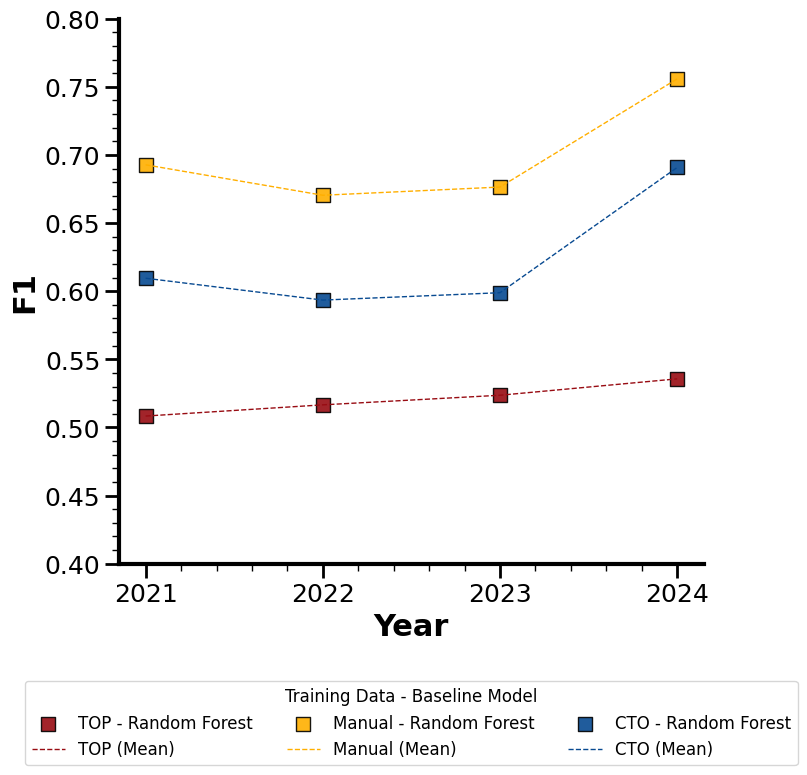

In [8]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
# Create a custom gold colormap for "manual"
gold_colormap = LinearSegmentedColormap.from_list("gold", ["#FFD700", "#FFA500", "#8B7500"])
bright_gold_colormap = LinearSegmentedColormap.from_list("bright_gold", ["#FFFF00", "#FFD700", "#FFA500"])

phase = 'all'
metric = 'f1_mean'
phase_result = output[output['phase'] == phase]
phase_result

result_dict = {}
train_mode = phase_result['train_mode'].unique()
# print(train_mode)
years = phase_result['year'].unique()
mode_name = {'TOP': 'TOP', 'manual': 'Manual', 'CTO': 'CTO'}
for mode in train_mode:
    result_dict[mode_name[mode]] = {}
    for year in years:
        result_dict[mode_name[mode]][str(year)] =phase_result[(phase_result['train_mode'] == mode) & (phase_result['year'] == year)][metric].values.tolist()
        # for model in phase_result['model'].unique():
        #     model_result = phase_result[(phase_result['train_mode'] == mode) & (phase_result['year'] == year) & (phase_result['model'] == model)]
        #     result_dict[mode][str(year)][model] = model_result[metric].values[0]



labels = ['Random Forest', 'Logistic Regression', 'XGBoost', 'MLP', 'SVM']
data = result_dict
train_modes = data.keys()

# Assigning colormaps for train modes
colormaps = {
    "TOP": plt.cm.Reds,
    "Manual": bright_gold_colormap,#plt.cm.Goldens,
    "CTO": plt.cm.Blues,
}
# colormaps = {
#     "CTO": plt.cm.Reds,
#     "Manual": bright_gold_colormap,#plt.cm.Goldens,
#     "TOP": plt.cm.Blues,
# }

# Assigning markers for models
markers = ["s", "o", "^", "D", "P"]  # Square, Circle, Triangle, Diamond, Pentagon




# fig, ax = plt.subplots(figsize=(8, 8))
fig, ax = plt.subplots(figsize=(8, 8))

for train_mode in train_modes:
    cmap = colormaps[train_mode]
    colors = cmap(np.linspace(0.9, 0.9, len(labels)))  # Different shades for each model
    years = sorted(data[train_mode].keys())

    for i, year in enumerate(years):
        values = list(data[train_mode][year])#.values())  # Extract F1 scores for models
        year_numeric = int(year)

        for j, value in enumerate(values):
            # Scatter plot for individual values
            ax.scatter(
                [year_numeric],  # x-value for the scatter point
                value,           # y-value
                color=colors[j],
                marker=markers[j],
                s=100,
                label=f"{train_mode} - {labels[j]}" if i == 0 else None,  # Label only for the first year
                alpha=0.9,
                edgecolor="black"
            )

    # Line plot connecting the mean values for the train mode
    year_means = [np.mean(list(data[train_mode][year])) for year in years]
    ax.plot(
        [int(year) for year in years],
        year_means,
        label=f"{train_mode} (Mean)",
        color=cmap(0.9),
        linestyle='--',
        linewidth=1
    )

# Customization
# ax.set_title("F1 Scores Over Years by Train Mode and Model", fontsize=14)
ax.set_xlabel("Year", fontsize=22, fontweight='bold')
ax.set_ylabel("F1", fontsize=22, fontweight='bold')
ax.set_xticks([int(year) for year in years])
ax.set_xticklabels(years,fontsize=18)

ax.set_ylim(0.4, 0.8)
# set fontsize for y-axis labels
ax.tick_params(axis='y', labelsize=18)
ax.spines['bottom'].set_color('black')
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_color('black')
ax.spines['left'].set_linewidth(3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.minorticks_on()
ax.tick_params(axis='both', which='major', width=2, length=10)
# ax.set_yticklabels(ax.get_yticks(), fontsize=14)
ax.tick_params(axis='both', which='minor', width=1, length=5)

ax.legend(title="Training Data - Baseline Model", bbox_to_anchor=(0.5, -0.2), loc="upper center", fontsize=12,title_fontsize=12,ncol=3)
plt.tight_layout()
